In [ ]:
#default_exp mixmethods

In [ ]:
#export
import torch
import torch.nn.functional as F
import numpy as np
from torch.distributions.beta import Beta
from torch.nn import Module
from torch import tensor
from functools import partial

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from lib.core import *

def test_func(func):
    df = load_dataset('../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv', 
                      im_dir='../../Datasets/cassava/train_images/', curr_fold=0, shuffle=True)
    ds = ds = DummyDataset(data=df)
    dl = DataLoader(ds, batch_size=8,)
    batch = next(iter(dl))
    x, y = batch
    return func(x,y)

In [ ]:
#export
# from : https://github.com/fastai/fastai/blob/493023513ddd5157647bd10e9cebbbbdc043474c/fastai/layers.py#L582
class NoneReduce():
    "A context manager to evaluate `loss_func` with none reduce."
    def __init__(self, loss_func): self.loss_func,self.old_red = loss_func,None

    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = self.loss_func.reduction
            self.loss_func.reduction = 'none'
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')

    def __exit__(self, type, value, traceback):
        if self.old_red is not None: self.loss_func.reduction = self.old_red

In [ ]:
#export
# modified from : https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py
class Mixup():
    "Implements mixup from https://arxiv.org/abs/1710.09412"
    def __init__(self, alpha: float = 0.4):
        self.distrib = Beta(tensor(alpha), tensor(alpha))
        self.device = None
        
    def __call__(self, xb:torch.Tensor, yb:torch.Tensor, model:Module=None):
        bs = xb.size()[0]
        
        if self.device is None: self.device = xb.device
        
        self.lam = self.distrib.sample().to(self.device)
        
        index = torch.randperm(bs, device=self.device)
        xb = self.lam * xb + (1 - self.lam) * xb[index, :]
        self.yb1, self.yb2 = yb, yb[index]
        return xb
    
    def loss(self, lf, pred, reduction='mean'):
        self.old_lf = lf
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred, self.yb2), lf(pred, self.yb1), self.lam)
        return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

tensor(1.2755) tensor([3, 3, 3, 3, 3, 3, 1, 2]) tensor([2, 3, 1, 3, 3, 3, 3, 3]) tensor(0.3541)


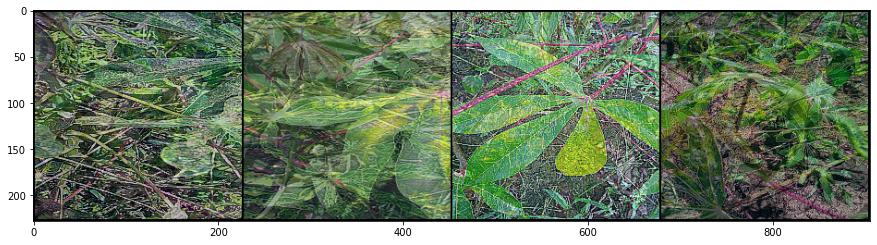

In [ ]:
lf = LabelSmoothingCrossEntropy()
mx = Mixup(0.7)

im = test_func(mx)
grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()

pred = F.one_hot(mx.yb1, len(idx2lbl)).float()
loss = mx.loss(lf, pred)

print(loss, mx.yb1, mx.yb2, mx.lam)

plt.figure(figsize=(15,15))
plt.imshow(grid)

In [ ]:
#export
#modified from : https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py
class Cutmix():
    "Implementation of `https://arxiv.org/abs/1905.04899`" 
    def __init__(self, alpha: float = 1.0):
        self.device = None
        self.distrib = Beta(tensor(alpha), tensor(alpha))
    
    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = torch.round(W * cut_rat).type(torch.long)
        cut_h = torch.round(H * cut_rat).type(torch.long)
        # uniform
        cx = torch.randint(0, W, (1,))
        cy = torch.randint(0, H, (1,))
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1.to(self.device), y1.to(self.device), x2.to(self.device), y2.to(self.device)
    
    def __call__(self, xb:torch.Tensor, yb:torch.Tensor, model:Module=None):
        bs, _, H, W = xb.size()
        
        if self.device is None: self.device = xb.device
        
        self.lam = self.distrib.sample().to(self.device)
        
        index = torch.randperm(bs, device=self.device)
        
        self.yb1, self.yb2 = yb, yb[index]
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        xb[:, :, x1:x2, y1:y2] = xb[index, :, x1:x2, y1:y2]
        # adjust lambda to exactly match pixel ratio
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H)).item()
        return xb
        
    def loss(self, lf, pred, reduction='mean'):
        self.old_lf = lf
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred, self.yb2), lf(pred, self.yb1), self.lam)
        return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

tensor(1.4348) tensor([1, 3, 3, 3, 0, 3, 3, 3]) tensor([3, 0, 3, 3, 1, 3, 3, 3]) 0.7877471446990967


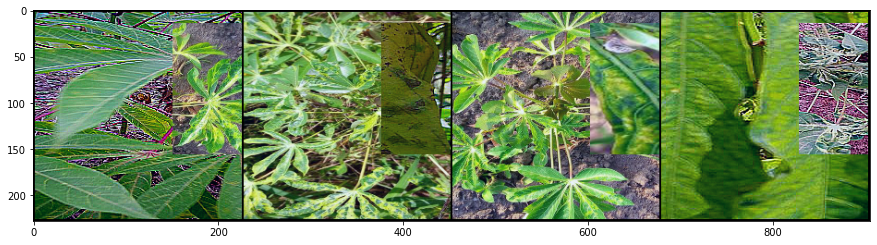

In [ ]:
cx = Cutmix()

im = test_func(cx)
grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()

pred = F.one_hot(mx.yb1, len(idx2lbl)).float()
loss = cx.loss(lf, pred)

print(loss, cx.yb1, cx.yb2, cx.lam)

plt.figure(figsize=(15,15))
plt.imshow(grid)

In [ ]:
#export
class SnapMix():
    "Implementation of https://arxiv.org/abs/2012.04846"
    pass